# Support Vector Machines Exercise
This exercise will guide you in implementing Support Vector Machines (SVM). 

**You will learn to implement two approaches of training an SVM:**
- Approach 1: Apply Simplified Sequential Minimal Optimization (SMO)
- Approach 2: Apply Gradient Descent with Hinge Loss

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

# Fix the seed of the random number 
# generator so that your results will match ours
np.random.seed(1)

%load_ext autoreload
%autoreload 2

## Simplified SMO Algorithm
This is patterned after Stanford cs229's notes. There are some minor differences in notation / convention with the original SMO paper such as $f(x)=W^Tx-b$ but here we use $f(x)=W^Tx+b$. As long as you are consistent and make sure that the math is equivalent then it is fine to use which ever you are more comfortable with. <br />

Original SMO paper: Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines <br />
Link: https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf

Recall: The dual optimization problem for support vector machines that we want to solve.<br />

$$
\begin{array}{lll}
    \max_\alpha & \quad \sum_{i=1}^N \alpha_i - \frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N y_i y_j \alpha_i \alpha_j \langle x_i, x_j \rangle \\
    \text{such that} & \quad 0 \leq \alpha_i \leq C, \forall_i \\
    \quad & \quad \sum_{i=1}^N \alpha_i y_i = 0
\end{array}
$$

We cannot use the ordinary optimization techniques that you have learned so far because of the constraints in the optimization problem. Moreover, the constraint $\sum_{i=1}^N \alpha_i y_i = 0$ prevents us from changing the $\alpha_i$'s one at a time. So if we want to update the $\alpha_i$'s we must update at least two of them simultaneously so we don't violate the constraints. 

Overview of SMO algorithm: <br />

`Repeat till convergence {` <br />
&ensp;&ensp; `1. Select some pair` $\alpha_i$ `and` $\alpha_j$ <br />
&ensp;&ensp; `2. Optimize the objective function with respect to` $\alpha_i$ `and` $\alpha_j$`, while holding all the other` $\alpha_k$`'s` $(k \neq i, j)$ `fixed. We also update the bias term` $b$. <br />
`}`

We can use the KKT optimality conditions to check if we have converged to the optimal point. Meaning any set of $\alpha$'s that satisfy all the conditions below will be an optimal solution to the dual optimization problem. So we iterate until all the conditions are met within a certain precision / tolerance.
\begin{align}
 \alpha_i = 0 & \implies y_i (W^Tx_i + b) \geq 1 \\
 \alpha_i = C & \implies y_i (W^Tx_i + b) \leq 1 \\
 0 < \alpha_i < C & \implies y_i (W^Tx_i + b) = 1
\end{align}


** Choosing $\alpha_i$ and $\alpha_j$ ** <br />
In the original paper, they presented various heuristics for choosing the best $\alpha_i$ and $\alpha_j$ to change in every iteration to optimize the objective function the fastest. This is critical for large data sets since there are $n(n-1)$ possible choices for $\alpha_i$ and $\alpha_j$. However, for the purposes of this exercise, we simplify the algorithm and just iterate over all $\alpha_i, i=1,...,N$ that has not yet fulfilled the KKT conditions, and select $\alpha_j$ at random from the remaining $N-1$ $\alpha$'s. The algorithm stops if none of the $\alpha$'s are changed after a few passes. Note that this simplified version does not guarantee convergence to the global optimum but will be sufficient for the datasets we consider. The reason for this simplification is that we want you to focus more on the optimization process rather than the heurstic for choosing the $\alpha$'s. If you are interested, you can try to implement the heuristics mentioned in the paper, but only after you have implemented this simplified version.

** Optimizing $\alpha_i$ and $\alpha_j$ ** <br />
After choosing which pair of $\alpha_i$ and $\alpha_j$ to update, we then find the value of $\alpha_j$ that maximizes the objective function.

$$\alpha_j := \alpha_j - y_j\frac{E_i - E_j}{\eta}$$

where,
\begin{align}
    E_i &= f(x_i) - y_i \\
    \eta &= 2\langle x_i,x_j\rangle-\langle x_i,x_i\rangle -\langle x_j,x_j\rangle
\end{align}

$\langle \cdot,\cdot \rangle$ denotes an inner product / dot product

**Note**: In the original paper, they also address the rare case when $\eta=0$. For this exercise, simply treat it as a case where we cannot make any progress on the current pair of $\alpha$'s.



We compute for the lower and upper bounds $(L \leq \alpha_j \leq H)$ of the possible values it can take on and still satisfy the constraints. 

Lower Bound $L$ and Upper Bound $H$:
\begin{align}
    \text{If } y_i \neq y_j, \quad L &= \max(0,\alpha_j-\alpha_i)\\
     H &= \min(C,C+\alpha_j-\alpha_i) \\ 
    \text{If } y_i = y_j,  \quad  L &= \max(0,\alpha_j+\alpha_i - C)\\ 
    \quad H &= \min(C,\alpha_j+\alpha_i) 
\end{align}

If the optimal value of $\alpha_j$ is outside of the bounds $[L,H]$, then we simply clip the value.

$$
\alpha_j = \left\{
        \begin{array}{lll}
            H & \quad \text{if} \quad \alpha_j > H \\
            \alpha_j & \quad \text{if} \quad L \leq \alpha_j \leq H \\
            L & \quad \text{if} \quad \alpha_j < L
        \end{array}
    \right.
$$

We can then solve for the optimal value of $\alpha_i$ using the equation below, where $\alpha_j^{(\text{old})}$ refers to the value of $\alpha_j$ before the update above.

$$\alpha_i = \alpha_i + y_iy_j(\alpha_j^{(\text{old})} - \alpha_j)$$

Next, we update the bias $b$ using the following formulas.

$$ b_1 = b - E_i - y_i(\alpha_i - \alpha_i^{(\text{old})})\langle x_i,x_i\rangle - y_j(\alpha_j-\alpha_j^{(\text{old})})\langle x_i,x_j\rangle$$
$$ b_2 = b - E_j - y_i(\alpha_i - \alpha_i^{(\text{old})})\langle x_i,x_j\rangle - y_j(\alpha_j-\alpha_j^{(\text{old})})\langle x_j,x_j\rangle$$

$$
b = \left\{
        \begin{array}{lll}
            b_1 & \quad \text{if} \quad 0 < \alpha_i < C \\
            b_2 & \quad \text{if} \quad 0 < \alpha_j < C \\
            \frac{(b_1 +b_2)}{2} & \quad \text{otherwise}
        \end{array}
    \right.
$$

**Open `svm.py`. **

Let's start with implementing a linear SVM case first

**(1.)** First implement `compute_weights`. $W = \sum_{i=1}^N \alpha_i y_i x_i$ 

**(2.)** Implement the function `f(x)` mathematically it is defined as $f(x)=W^Tx+b$.

**(3.)** Implement the function `train`. All the formulas you need are already listed above.

**(4.)** Implement the function `predict`. 

Shape of X (100, 2)
Shape of y (100,)


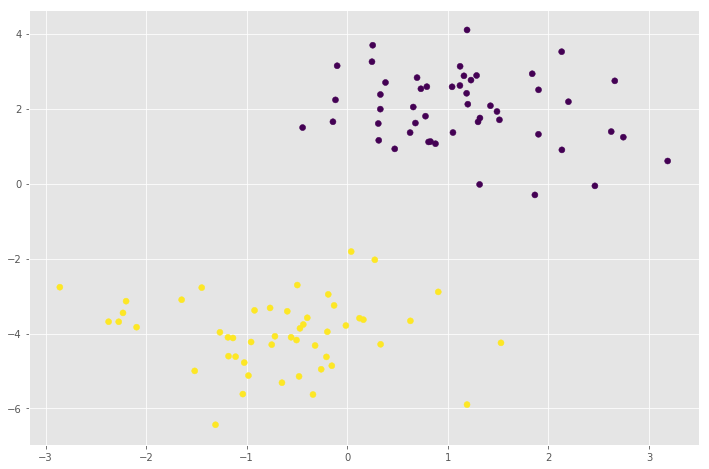

In [16]:
from sklearn.datasets import make_blobs
np.random.seed(1)
centers = [[1, 2], [-1, -4]]
X, y = make_blobs(n_samples=100, centers=centers)
y[y == 0] = -1
plt.scatter(X[:,0], X[:,1],c=y)
print("Shape of X",X.shape)
print("Shape of y", y.shape)

In [3]:
from svm import SupportVectorMachine

In [4]:
classifier = SupportVectorMachine(C=1.0, epsilon=1e-4, max_passes=10)

In [5]:
classifier.train(X,y)

In [6]:
y_pred = classifier.predict(X)
print("Accuracy", np.sum(y_pred == y) / y.shape[0])

Accuracy 1.0


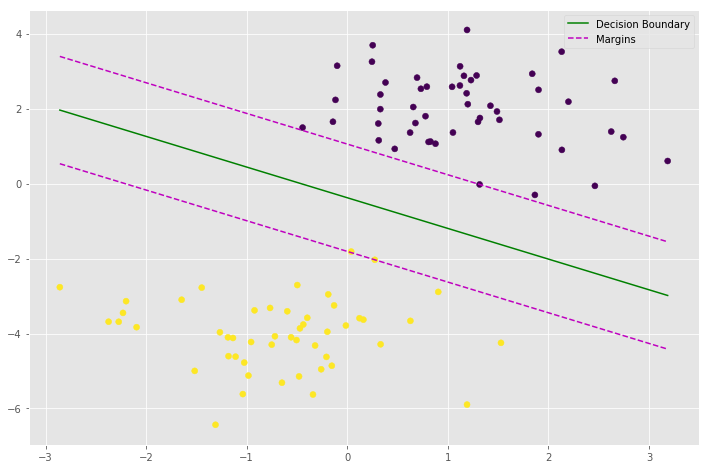

In [7]:
b = classifier.params["b"]
W = classifier.params["W"]

plt.scatter(X[:,0], X[:,1],c=y)
# plot decision boundary for 2D case
x_1 = np.min(X[:,0])
y_1 = (-b - W[0]*x_1) / W[1]
x_2 = np.max(X[:,0])
y_2 = (-b - W[0]*x_2) / W[1]

plt.plot([x_1, x_2], [y_1, y_2],'g',label="Decision Boundary")

# plot margins
x_1_a = np.min(X[:,0])
y_1_a = (1 - b - W[0]*x_1) / W[1]
x_2_a = np.max(X[:,0])
y_2_a = (1 - b - W[0]*x_2) / W[1]
plt.plot([x_1_a, x_2_a], [y_1_a, y_2_a],'--m')

x_1_b = np.min(X[:,0])
y_1_b = (-1 - b - W[0]*x_1) / W[1]
x_2_b = np.max(X[:,0])
y_2_b = (-1 - b - W[0]*x_2) / W[1]
plt.plot([x_1_b, x_2_b], [y_1_b, y_2_b],'--m', label="Margins")
plt.legend()



## Kernel SVM
We can extend SVM's to produce non-linear decision boundaries through kernels. This is similar to the feature transform that you did for the polynomial regression. The difference is that kernels gives you a way to get the same output without explicitly performing the feature transform (which may be expensive to compute specially for very high dimensional transforms). It can even represent an infinite dimensional transform such as the Gaussian / Radial Basis Function (RBF) kernel which in theory can linearly separate any data. However, without proper tuning and regularization, we risk overfitting to the training data which makes your classifier useless since it cannot generalize to unseen data.

To apply kernels, we simply replace all instances of the inner product $\langle \cdot,\cdot \rangle$ with the kernel $K(\cdot,\cdot)$. Note that $W = \sum_{i=1}^N \alpha_i y_i x_i$, which implies that $f(z) = W^Tz+b = \sum_{i=1}^N \alpha_i y_i \langle x_i, z\rangle +b$. So you will need to modify the some of the functions to apply the kernel.

Some commonly used kernels:
- Polynomial kernel: $K(x,z) = (x^Tz+c)^d$. Where $d$ is the degree of the polynomial and $c$ is a hyperparameter set by the user
- Gaussian / Radial Basis Function (RBF) Kernel: $K(x,z) = \exp \bigl( -\frac{\Vert x-z \Vert^2}{2\sigma^2}\bigr)$


Shape of X (200, 2)
Shape of y (200,)


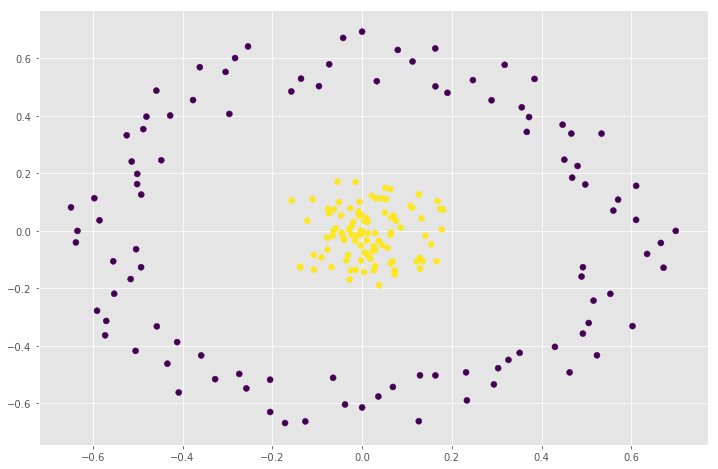

In [8]:
def generate_dummy_circle_data(num_points):
    r = np.random.uniform(0,0.2,num_points)
    theta = np.random.uniform(0,2*np.pi,num_points)
    inner_circle = np.array([r*np.sin(theta), r*np.cos(theta)]).T
    
    r = np.random.uniform(0.5,0.7,num_points)
    theta = 2*np.pi*np.arange(num_points)/num_points
    outer_circle = np.array([r*np.sin(theta), r*np.cos(theta)]).T

    X = np.concatenate((inner_circle,outer_circle),axis=0)
    y = np.concatenate((np.ones(num_points),-np.ones(num_points)),axis=0)
    
    randIdx = np.arange(X.shape[0])
    np.random.shuffle(randIdx)
    
    X = X[randIdx]
    y = y[randIdx].astype(int)
    
    return X, y
X,y = generate_dummy_circle_data(100)

print("Shape of X", X.shape)
print("Shape of y", y.shape)

plt.scatter(X[:,0],X[:,1],c=y)

In [9]:
classifier = SupportVectorMachine(C=1.0, epsilon=1e-4, max_passes=10, kernel_fn="rbf",sigma=0.6)

In [10]:
classifier.train(X,y)

In [11]:
y_pred = classifier.predict(X)
print("Accuracy", np.sum(y_pred == y) / y.shape[0])

Accuracy 1.0


(-0.86854236935431794, 0.89318661300394431)

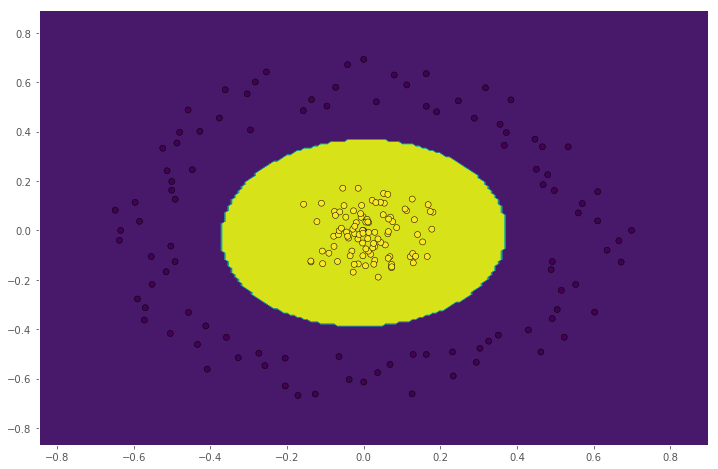

In [12]:
# visualize the decision boundary
x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))


x_test = np.squeeze(np.stack((xx.ravel(),yy.ravel()))).T
k_vals = [1,2,3,5,6,7,8,9,10]

Z = classifier.predict(x_test)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='black')
plt.xlim([x_min,x_max])
plt.ylim([y_min,y_max])


Shape of X (30, 2)
Shape of y (30,)


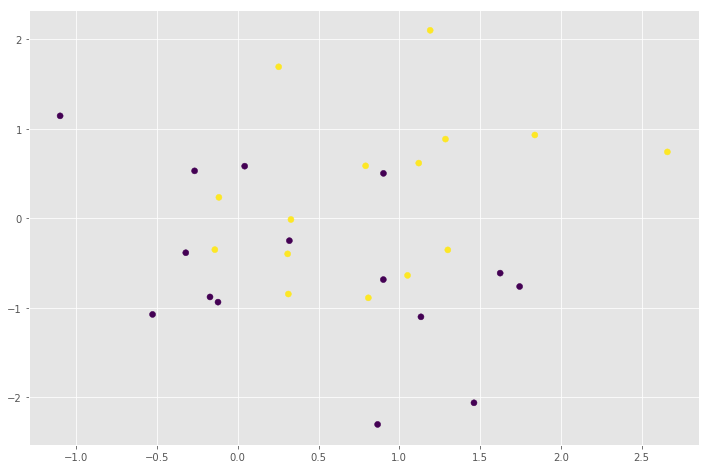

In [17]:
np.random.seed(1)
centers = [[0, 0], [1, 0]]
X, y = make_blobs(n_samples=30, centers=centers)
y[y == 0] = -1
plt.scatter(X[:,0], X[:,1],c=y)
print("Shape of X",X.shape)
print("Shape of y", y.shape)

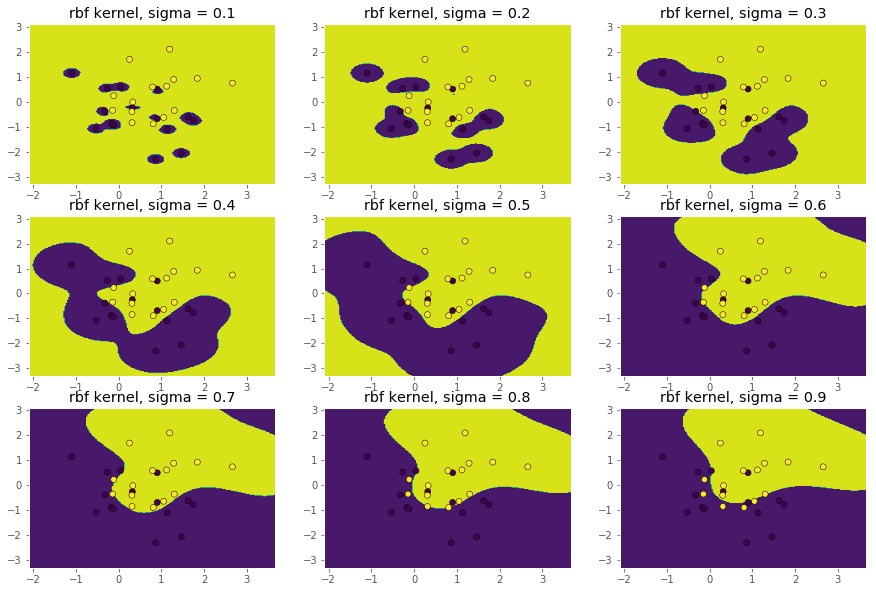

In [18]:
# visualize the decision boundary as sigma increases
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))


x_test = np.squeeze(np.stack((xx.ravel(),yy.ravel()))).T
sigma_vals = np.arange(0.1, 1.0, 0.1)
plt.figure(figsize=(15,10))
plt_ctr = 1
for sigma in sigma_vals:

    classifier = SupportVectorMachine(C=1.0, epsilon=1e-4, max_passes=10, kernel_fn="rbf",sigma=sigma)
    classifier.train(X,y)
    Z = classifier.predict(x_test)
    Z = Z.reshape(xx.shape)
    plt.subplot(3,3,plt_ctr)
    plt.contourf(xx, yy, Z)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='black')
    plt.xlim([x_min,x_max])
    plt.ylim([y_min,y_max])
    plt.title("rbf kernel, sigma = " + str(sigma))
    plt_ctr += 1

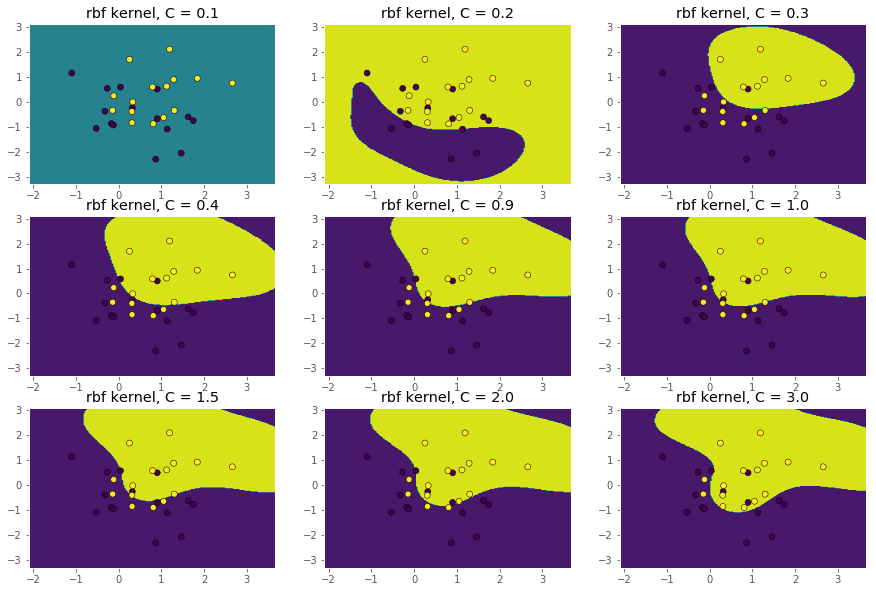

In [19]:
# visualize the decision boundary as C varies
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))


x_test = np.squeeze(np.stack((xx.ravel(),yy.ravel()))).T
C_vals = [0.1, 0.2 , 0.3 , 0.4, 0.9, 1.0, 1.5, 2.0, 3.0]
plt.figure(figsize=(15,10))
plt_ctr = 1
for C in C_vals:

    classifier = SupportVectorMachine(C=C, epsilon=1e-4, max_passes=10, kernel_fn="rbf",sigma=1.0)
    classifier.train(X,y)
    Z = classifier.predict(x_test)
    Z = Z.reshape(xx.shape)
    plt.subplot(3,3,plt_ctr)
    plt.contourf(xx, yy, Z)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='black')
    plt.xlim([x_min,x_max])
    plt.ylim([y_min,y_max])
    plt.title("rbf kernel, C = " + str(C))
    plt_ctr += 1